In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sns
from matplotlib import pyplot as plt
import pyGadget

In [2]:
sns.set_context('poster')

In [3]:
rad = 1e5
views = {'native':None, 'face (xy)':'face', 'xz':'xz', 'yz':'yz'}
particles = {'x':[], 'y':[], 'z':[], 'n':[], 'view':[], 'snapshot':[]}
for sim, snap in [('vanilla',355), ('xr_tau_J0',306), ('xr_tau_J1',327), ('xr_tau_J2',271), ('xr_tau_J3',235)]:
    sim = pyGadget.sim.Simulation('stampede/'+sim,length='AU')
    s = sim.load_snapshot(snap)
    s.gas.load_coords()
    for v in ['native', 'face (xy)', 'xz', 'yz']:
        vv = views[v]
        s.gas.orient_box(centering='max', view=vv)
        r2d = np.linalg.norm(s.gas.coordinates[:,:2], axis=1)
        pos, n = pyGadget.analyze.data_slice(r2d < rad, s.gas.coordinates, s.gas.ndensity)
        particles['x'].extend(pos[:,0])
        particles['y'].extend(pos[:,1])
        particles['z'].extend(pos[:,2])
        particles['n'].extend(n)
        particles['view'].extend([v for i in range(n.size)])
        particles['snapshot'].extend([snap for i in range(n.size)])

    s.gas.cleanup()
    s.close()

Turning on gas particle refinement.
There are 8000000 highest resolution particles.
Density maximum box center: 5.694e+08 5.686e+08 5.615e+08
Density maximum box center: 4.240e-01 -1.249e-01 -1.085e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Turning on gas particle refinement.
There are 8000000 highest resolution particles.
Density maximum box center: 5.689e+08 5.681e+08 5.610e+08
Density maximum box center: 1.070e-01 -2.904e-01 -9.697e-01
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum box center: 0.000e+00 0.000e+00 0.000e+00
Density maximum 

In [4]:
particles = pd.DataFrame(particles)
particles['log z'] = np.log10(particles['z'])
particles['log n'] = np.log10(particles['n'])

/home/r900-4/jhummel/bin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from IPython.kernel.zmq import kernelapp as app
/home/r900-4/jhummel/bin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from IPython.kernel.zmq import kernelapp as app


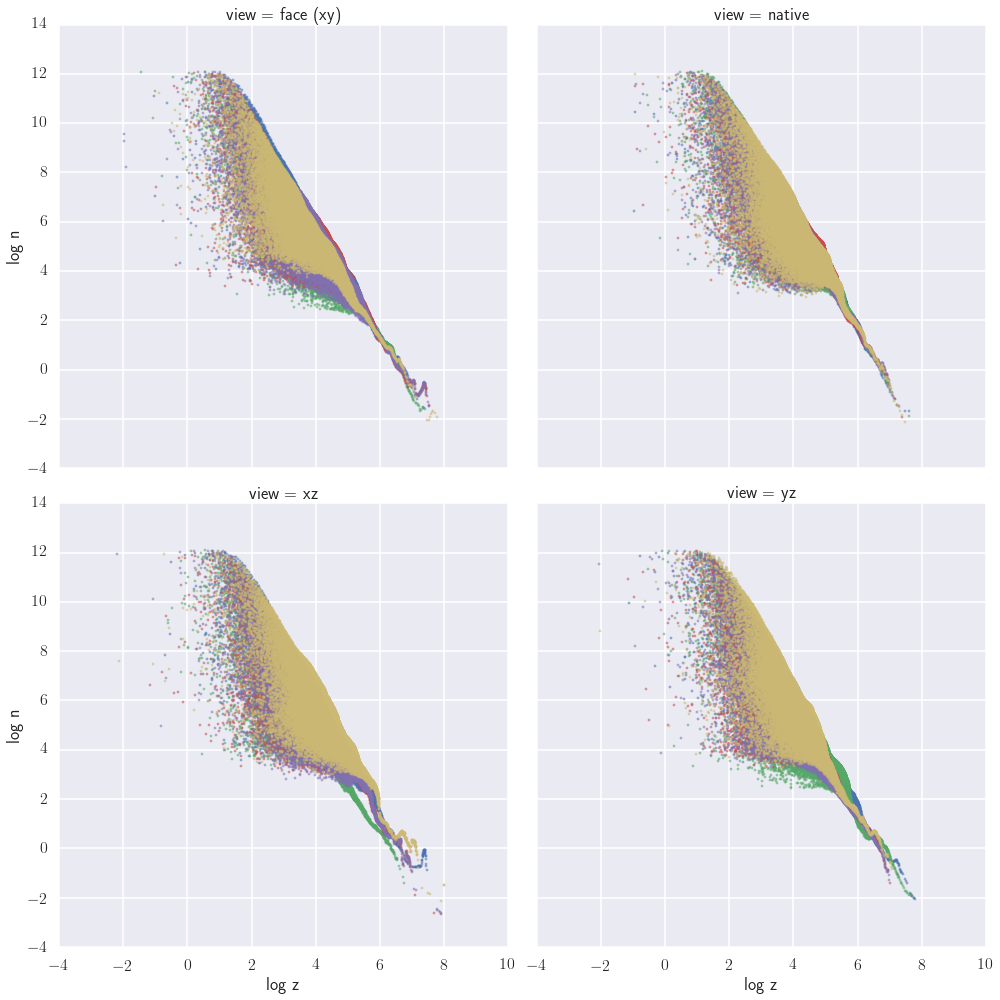

In [22]:
g = sns.FacetGrid(particles, col='view', hue='snapshot', col_wrap=2, size=7)
g.map(plt.scatter, 'log z', 'log n', s=5, alpha=.5)#, linewidth=.5, edgecolor="white")

In [23]:
g.fig.savefig('figures/optical_depth/views-overlay.png', bbox_inches='tight')

# Interpolating Column with griddata

In [7]:
xmax = ymax = 1
xmin = ymin = -1
zmax = 1e7
zmin = 0
(zmax-zmin)

10000000.0

In [8]:
grid_x, grid_y, grid_z = np.mgrid[xmin:xmax:3j, ymin:ymax:3j, zmin:zmax:10000001j]

In [9]:
grid_z.shape, grid_z.size

((3, 3, 10000001), 90000009)

In [ ]:
z = grid_z[1,1]
z[1] - z[0] #Double-check grid spacing!

1.0

In [ ]:
sigma = 1.14e-23
optical_depth = {'z':[], 'n':[], 'N':[], 'tau':[], 'view':[], 'snapshot':[]}
for snap in [355, 306, 327, 271, 235]:
    for view in ['native', 'face (xy)', 'xz', 'yz']:
        selection = particles[(particles['view'] == view) & (particles['snapshot'] == snap)]
        pos = np.column_stack([selection['x'].values, selection['y'].values, selection['z'].values])
        n = selection['n'].values
        grid_n = griddata(pos, n, (grid_x, grid_y, grid_z), method='linear')
        nz = grid_n[1,1]
        N = nz[::-1].cumsum() * 1.49597871e13 #convert from AU to cm
        tau = N[::-1] * sigma
        print snap, view, tau[0]
        optical_depth['z'].extend(z)
        optical_depth['n'].extend(nz)
        optical_depth['N'].extend(N[::-1])
        optical_depth['tau'].extend(tau)
        optical_depth['view'].extend([view for i in range(z.size)])
        optical_depth['snapshot'].extend([snap for i in range(z.size)])
optical_depth = pd.DataFrame(optical_depth)

355 native 8793.8607076
355 face (xy) 5626.76440626
355 xz 8266.0045326
355 yz 11596.0033682
306 native 8170.55102923
306 face (xy) 5784.31705566
306 xz 5593.0626288
306 yz nan
327 native nan
327 face (xy) 5304.9431026
327 xz 7372.90952241
327 yz nan
271 native 10444.0470898
271 face (xy) 5369.56153246
271 xz nan
271 yz 8892.31485641
235 native 9552.19227308
235 face (xy) 7245.54945975
235

In [3]:
store = pd.HDFStore("/home/r900-4/jhummel/data/simdata/xrays/optical_depth_referee.hdf5")

In [4]:
#store['particles'] = particles
#store['optical_depth'] = optical_depth
optical_depth = store['optical_depth']

In [5]:
store.close()

In [6]:
optical_depth[optical_depth['z'] == 0]

/home/r900-4/jhummel/bin/anaconda/lib/python2.7/site-packages/pandas/core/format.py:1998: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e8).any()
/home/r900-4/jhummel/bin/anaconda/lib/python2.7/site-packages/pandas/core/format.py:1999: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) &
/home/r900-4/jhummel/bin/anaconda/lib/python2.7/site-packages/pandas/core/format.py:2000: RuntimeWarning: invalid value encountered in greater
  (abs_vals > 0)).any()


,N,n,snapshot,tau,view,z
0,7.713913e+26,1.038198e+12,355,8793.860708,native,0
10000001,4.935758e+26,1.038198e+12,355,5626.764406,face (xy),0
20000002,7.250881e+26,1.038198e+12,355,8266.004533,xz,0
30000003,1.017193e+27,1.038198e+12,355,11596.003368,yz,0
40000004,7.167150e+26,1.131331e+12,306,8170.551029,native,0
50000005,5.073962e+26,1.131331e+12,306,5784.317056,face (xy),0
60000006,4.906195e+26,1.131331e+12,306,5593.062629,xz,0
70000007,NaN,1.131331e+12,306,NaN,yz,0
80000008,NaN,1.211225e+12,327,NaN,native,0
90000009,4.653459e+26,1.000146e+12,327,5304.943103,face (xy),0


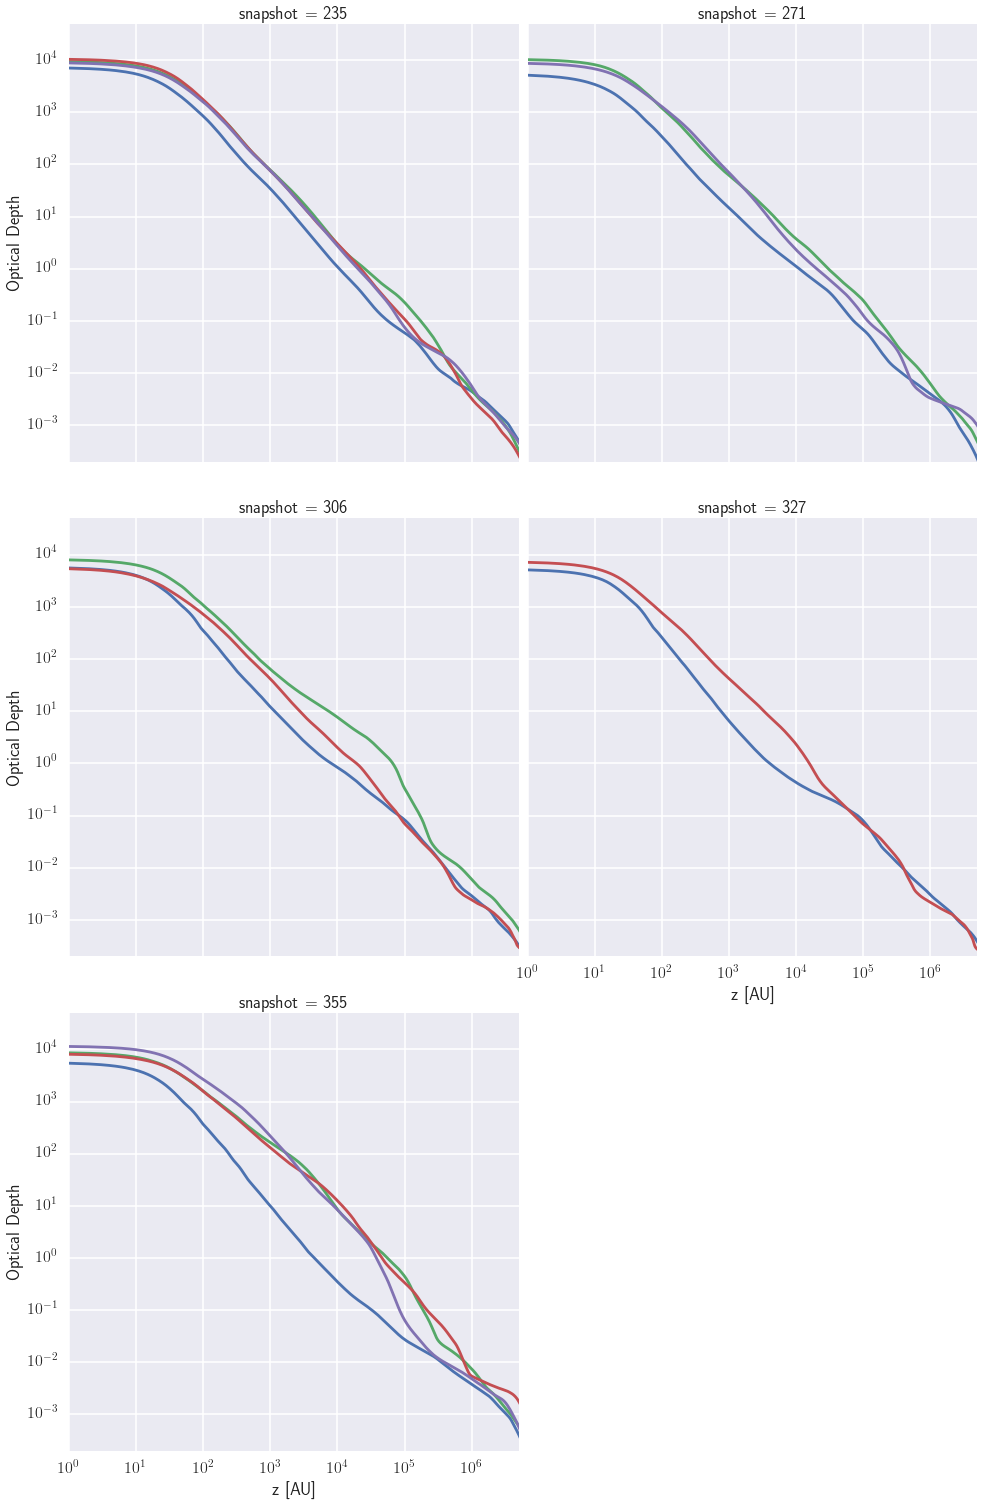

In [7]:
g = sns.FacetGrid(optical_depth, col='snapshot', hue='view', col_wrap=2, size=7)
g.map(plt.loglog, 'z', 'tau')
g.set(xlim=(1,5e6), ylim=(2e-4, 5e4))
g.set_xlabels('z [AU]')
g.set_ylabels('Optical Depth')
g.fig.subplots_adjust(wspace=.02)

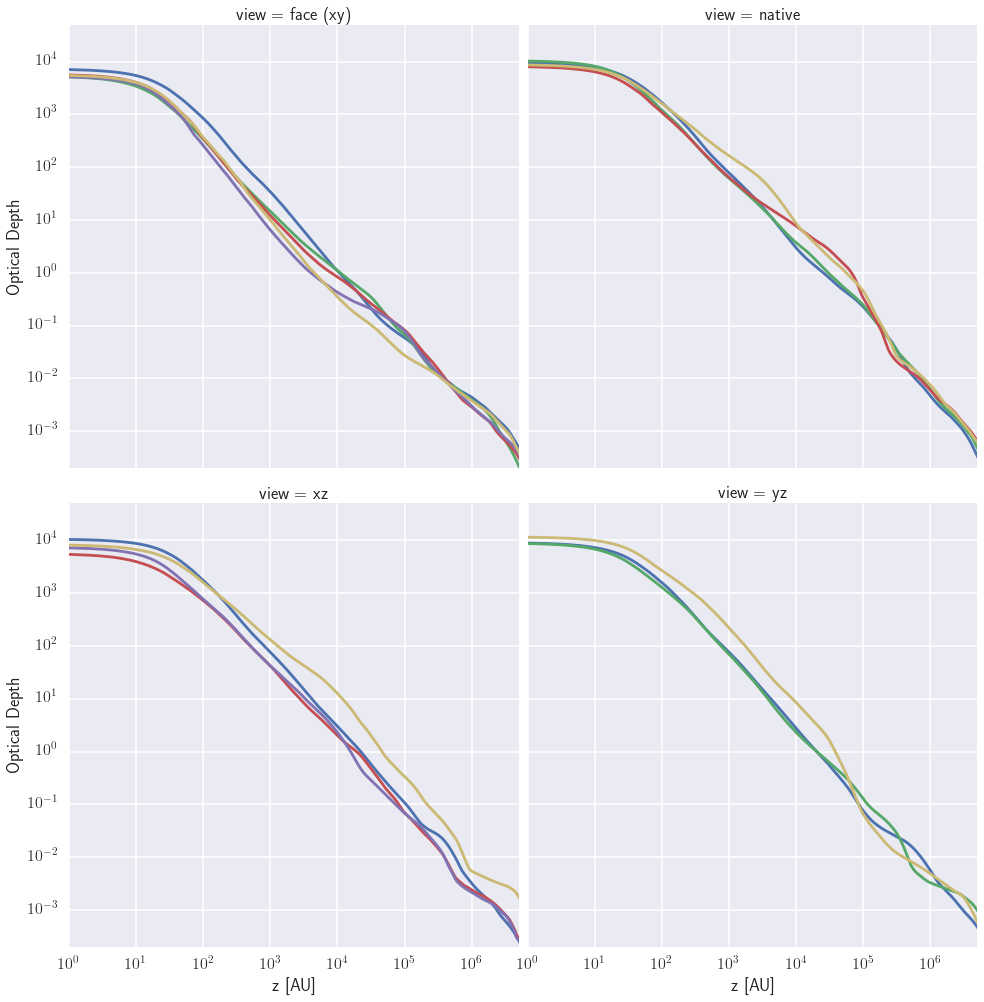

In [8]:
g = sns.FacetGrid(optical_depth, col='view', hue='snapshot', col_wrap=2, size=7)
g.map(plt.loglog, 'z', 'tau')
g.set(xlim=(1,5e6), ylim=(2e-4, 5e4))
g.set_xlabels('z [AU]')
g.set_ylabels('Optical Depth')
g.fig.subplots_adjust(wspace=.02)

In [9]:
g.fig.savefig('figures/optical_depth/optical_depth-r.png', bbox_inches='tight')

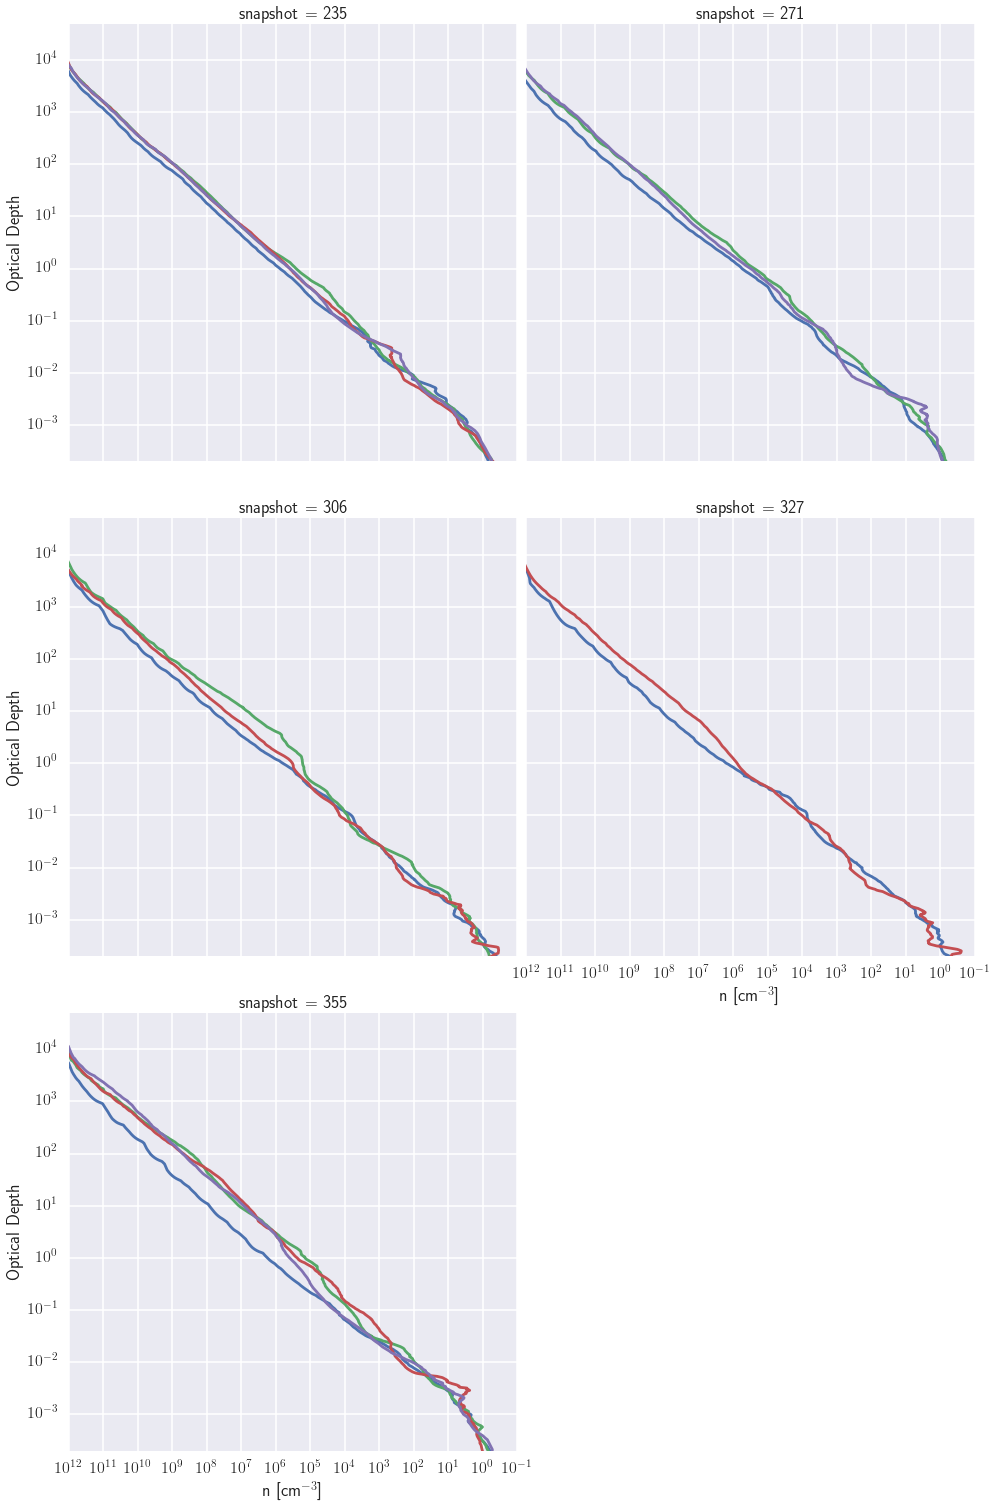

In [10]:
g = sns.FacetGrid(optical_depth, col='snapshot', hue='view', col_wrap=2, size=7)
g.map(plt.loglog, 'n', 'tau')
g.set(xlim=(1e12,.1), ylim=(2e-4, 5e4))
g.set_xlabels('n [cm$^{-3}$]')
g.set_ylabels('Optical Depth')
g.fig.subplots_adjust(wspace=.02)

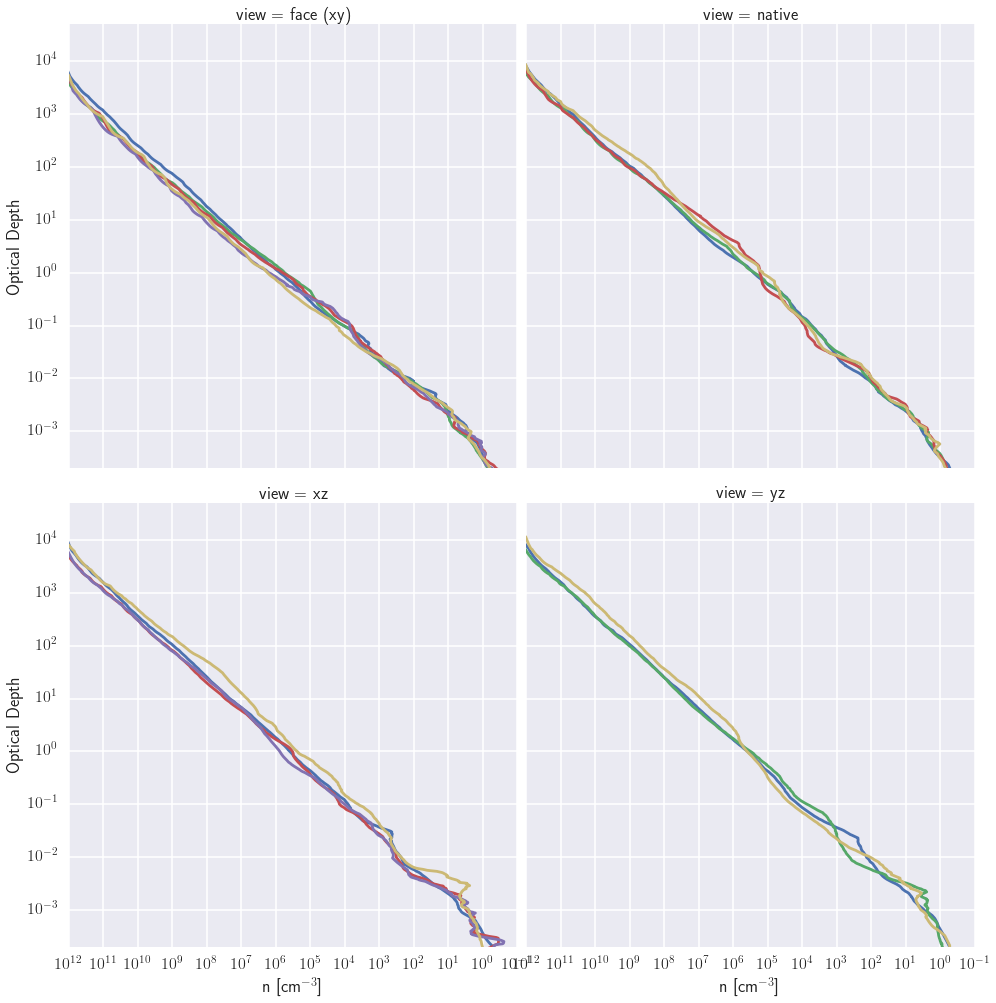

In [11]:
g = sns.FacetGrid(optical_depth, col='view', hue='snapshot', col_wrap=2, size=7)
g.map(plt.loglog, 'n', 'tau')
g.set(xlim=(1e12,.1), ylim=(2e-4, 5e4))
g.set_xlabels('n [cm$^{-3}$]')
g.set_ylabels('Optical Depth')
g.fig.subplots_adjust(wspace=.02)

In [12]:
g.fig.savefig('figures/optical_depth/optical_depth-n.png', bbox_inches='tight')

In [13]:
print 'done'

done
